In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Generation du dataset
n = 1000

education_levels = ['Sans diplome', 'Brevet', 'Bac', 'BTS/DUT', 'Licence', 'Master', 'Doctorat']
occupations = ['Administratif', 'Commercial', 'Technique', 'Cadre', 'Direction', 'Artisan', 'Ouvrier']
sectors = ['Public', 'Prive', 'Independant']
marital_status = ['Celibataire', 'Marie(e)', 'Divorce(e)', 'Veuf(ve)']
regions = ['Ile-de-France', 'PACA', 'Auvergne-Rhone-Alpes', 'Nouvelle-Aquitaine', 'Autres']

df = pd.DataFrame({
    'age': np.random.randint(18, 70, n),
    'education': np.random.choice(education_levels, n, p=[0.05, 0.10, 0.20, 0.20, 0.20, 0.20, 0.05]),
    'occupation': np.random.choice(occupations, n),
    'secteur': np.random.choice(sectors, n, p=[0.25, 0.60, 0.15]),
    'heures_semaine': np.random.randint(20, 60, n),
    'experience': np.random.randint(0, 45, n),
    'situation_familiale': np.random.choice(marital_status, n, p=[0.30, 0.50, 0.15, 0.05]),
    'nb_enfants': np.random.choice([0, 1, 2, 3, 4], n, p=[0.25, 0.25, 0.30, 0.15, 0.05]),
    'region': np.random.choice(regions, n, p=[0.25, 0.15, 0.15, 0.10, 0.35]),
    'teletravail': np.random.choice(['Jamais', 'Partiel', 'Complet'], n, p=[0.50, 0.35, 0.15]),
    'anciennete_poste': np.random.randint(0, 30, n),
    'satisfaction': np.random.uniform(1, 10, n).round(1)
})

# Variable cible basee sur des criteres realistes
education_score = df['education'].map({
    'Sans diplome': 0, 'Brevet': 1, 'Bac': 2, 'BTS/DUT': 3,
    'Licence': 4, 'Master': 5, 'Doctorat': 6
})

occupation_score = df['occupation'].map({
    'Ouvrier': 0, 'Artisan': 1, 'Administratif': 2, 'Technique': 3,
    'Commercial': 4, 'Cadre': 5, 'Direction': 6
})

salaire_score = (
    df['age'] * 0.02 +
    education_score * 0.8 +
    occupation_score * 0.6 +
    df['experience'] * 0.05 +
    df['heures_semaine'] * 0.03 +
    (df['secteur'] == 'Prive').astype(int) * 0.5 +
    (df['region'] == 'Ile-de-France').astype(int) * 0.8 +
    np.random.normal(0, 1, n)
)

df['salaire_50k'] = (salaire_score > np.percentile(salaire_score, 75)).astype(int)

# Valeurs manquantes
missing_cols = {
    'experience': 40,
    'heures_semaine': 25,
    'satisfaction': 50,
    'teletravail': 30,
    'nb_enfants': 20
}

for col, n_missing in missing_cols.items():
    df.loc[np.random.choice(n, n_missing, replace=False), col] = np.nan

### Tache 1.1 : Exploration initiale

1. Quelles sont les dimensions du dataset ?
2. Quels sont les types de chaque colonne ?
3. Combien de valeurs manquantes par colonne ?
4. Quelle est la distribution de la variable cible ?

In [2]:
df.head()

,age,education,occupation,secteur,heures_semaine,experience,situation_familiale,nb_enfants,region,teletravail,anciennete_poste,satisfaction,salaire_50k
0,56,BTS/DUT,Cadre,Independant,41.0,6.0,Celibataire,2.0,Autres,Partiel,2,3.6,0
1,69,Bac,Technique,Prive,28.0,3.0,Marie(e),0.0,Autres,Jamais,22,5.9,0
2,46,Bac,Artisan,Prive,48.0,18.0,Divorce(e),1.0,Nouvelle-Aquitaine,Partiel,13,1.2,0
3,32,BTS/DUT,Direction,Public,56.0,41.0,Celibataire,1.0,Autres,Complet,29,1.7,0
4,60,Sans diplome,Cadre,Independant,42.0,29.0,Celibataire,0.0,Autres,Jamais,14,NaN,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1000 non-null   int32  
 1   education            1000 non-null   object 
 2   occupation           1000 non-null   object 
 3   secteur              1000 non-null   object 
 4   heures_semaine       975 non-null    float64
 5   experience           960 non-null    float64
 6   situation_familiale  1000 non-null   object 
 7   nb_enfants           980 non-null    float64
 8   region               1000 non-null   object 
 9   teletravail          970 non-null    object 
 10  anciennete_poste     1000 non-null   int32  
 11  satisfaction         950 non-null    float64
 12  salaire_50k          1000 non-null   int64  
dtypes: float64(4), int32(2), int64(1), object(6)
memory usage: 93.9+ KB


In [4]:
df.describe()

,age,heures_semaine,experience,nb_enfants,anciennete_poste,satisfaction,salaire_50k
count,1000.00000,975.000000,960.000000,980.000000,1000.000000,950.000000,1000.000000
mean,43.81900,39.716923,22.475000,1.481633,14.655000,5.430842,0.250000
std,14.99103,11.282897,12.881889,1.148196,8.514486,2.582850,0.433229
min,18.00000,20.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,31.00000,30.500000,12.000000,0.000000,7.000000,3.200000,0.000000
50%,44.00000,39.000000,23.000000,1.000000,15.000000,5.400000,0.000000
75%,56.00000,49.000000,33.000000,2.000000,22.000000,7.700000,0.250000
max,69.00000,59.000000,44.000000,4.000000,29.000000,10.000000,1.000000


In [5]:
def analyse_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame({
        "Colonnes": missing.index,
        "Valeurs manquantes": missing.values,
        "Pourcentages": missing_pct.values
    })
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values("Pourcentages", ascending=False)
    return df_missing

missing_data = analyse_missing_date(df)
missing_data.head(len(missing_data))

,Colonnes,Valeurs manquantes,Pourcentages
11,satisfaction,50,5.0
5,experience,40,4.0
9,teletravail,30,3.0
4,heures_semaine,25,2.5
7,nb_enfants,20,2.0


Conclusion :
- Présence de valeurs manquantes dans les colonnes satisfaction, experience, teletravail, heures_semaine et nb_enfants

[Text(0, 0, '<=50k'), Text(1, 0, '>50k')]

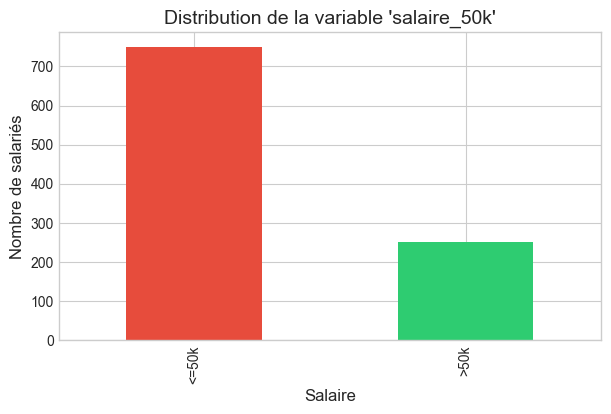

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
df["salaire_50k"].value_counts().plot(kind="bar", color=["#E74C3C", "#2ECC71"], ax=ax)
ax.set_title("Distribution de la variable 'salaire_50k'", fontsize=14)
ax.set_xlabel("Salaire", fontsize=12)
ax.set_ylabel("Nombre de salariés", fontsize=12)
ax.set_xticklabels(labels=["<=50k", ">50k"])

Conslusion :
- Déséquilibre des classes pour la variable "salaire_50k".

### Tache 1.2 : Identifier les types de variables

Classifiez les variables en :

- **Numeriques** : variables continues ou discretes
- **Categorielles nominales** : sans ordre naturel
- **Categorielles ordinales** : avec un ordre logique

In [ ]:
features_to_keep = [
    "age",
    "education",
    "occupation",
    "secteur",
    "heures_semaine",
    "experience",
    "situation_familiale",
    "nb_enfants", "region",
    "teletravail",
    "anciennete_poste",
    "satisfaction"
]
target = "salaire_50k"

X = df[features_to_keep].copy()
y = df[target].copy()

numeric_features = X.select_dtypes(include=["int", "float"]).columns.to_list()
nominal_features = X.select_dtypes(include=["object"]).drop(["education", "teletravail", "occupation"], axis=1).columns.to_list()
ordinal_features = X[["education", "teletravail", "occupation"]].select_dtypes(include=["object"]).columns.to_list()

print(f"Variables numériques : {numeric_features}")
print(f"Variables nominales : {nominal_features}")
print(f"Variables ordinales : {ordinal_features}")

Variables numériques : ['age', 'heures_semaine', 'experience', 'nb_enfants', 'anciennete_poste']
Variables nominales : ['secteur', 'situation_familiale', 'region']
Variables ordinales : ['education', 'teletravail', 'occupation']


### Tache 1.3 : Visualisations exploratoires

Creez des visualisations pertinentes :

1. Distribution de l'age selon le salaire (>50k ou non)
2. Relation entre education et salaire
3. Heatmap des correlations numeriques

Text(0, 0.5, 'Taux de salaire > 50k')

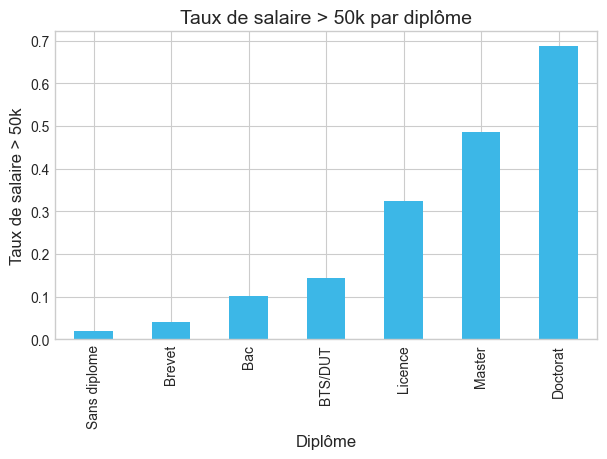

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
education_class = df.groupby("education")["salaire_50k"].mean().sort_values()
education_class.plot(kind="bar", color="#3CB7E7", ax=ax)
ax.set_title("Taux de salaire > 50k par diplôme", fontsize=14)
ax.set_xlabel("Diplôme", fontsize=12)
ax.set_ylabel("Taux de salaire > 50k", fontsize=12)

Conclusion :
- Plus le niveau de diplôme augmente, plus le taux de salaire > 50 k augmente.

In [121]:
df_corr = df.select_dtypes(include=["int", "float"]).copy()
mat_corr = df_corr.corr()

<Axes: title={'center': 'Matrice de corrélation'}>

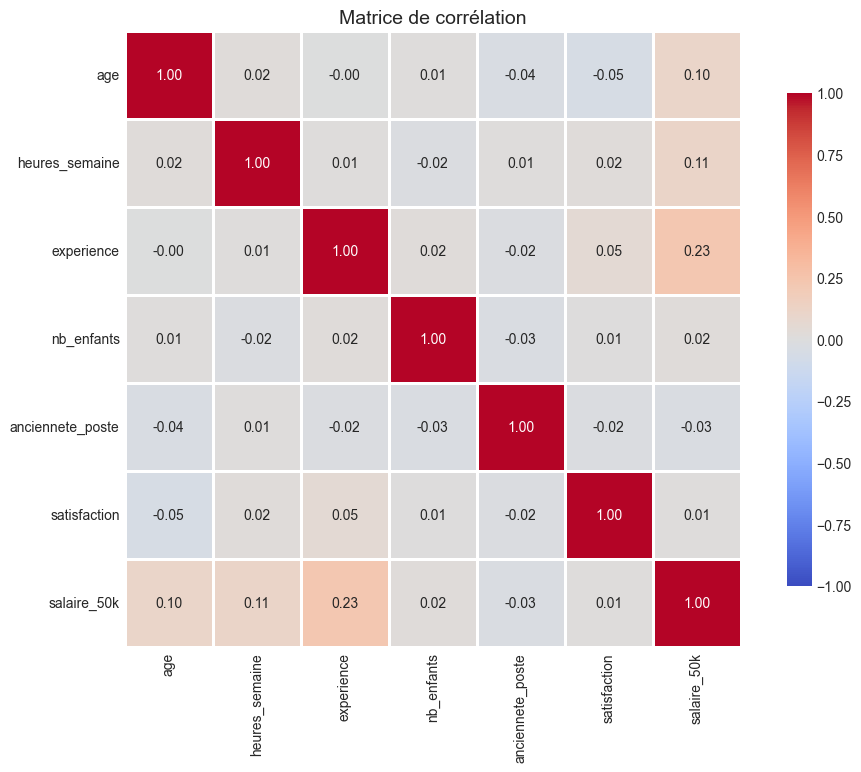

In [122]:
plt.figure(figsize=(12,8))
plt.title("Matrice de corrélation", fontsize=14)

sns.heatmap(
    mat_corr,
    annot=True, # Afficher les valeurs
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True, # Cases carrées
    linewidths=1, # Séparation entre les cases
    cbar_kws={"shrink": 0.8}, # Barre de couleur
    fmt=".2f", # Arrondir les valeurs à 2 décimales
)

Conclusion :
- Aucune corrélation forte

## Partie 2 : Preparation des donnees

### Tache 2.1 : Separation Train/Test

Separez les donnees en :

- Features (X) et target (y)
- Train (80%) et Test (20%)
- Utilisez `stratify=y` pour conserver la distribution de la cible

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True,
)

## Partie 3 : Construction du Pipeline

### Tache 3.1 : Pipeline pour variables numeriques

Creez un pipeline qui :

1. Impute les valeurs manquantes avec la mediane
2. Standardise les donnees

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), # remplacer les NaN par la médiane
        ("scaler", StandardScaler()), # Normaliser les données
    ]
)

### Tache 3.2 : Pipeline pour variables nominales

Creez un pipeline qui :

1. Impute les valeurs manquantes avec le mode
2. Applique One-Hot Encoding

In [125]:
# Pipeline pour les variables nominales
nominal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), # remplacer les NaN par le mode
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### Tache 3.3 : Pipeline pour variables ordinales

Creez un pipeline qui :

1. Impute les valeurs manquantes avec le mode
2. Applique Ordinal Encoding avec l'ordre correct

In [274]:
education = ["Sans diplome", "Brevet", "Bac", "BTS/DUT", "Licence", "Master", "Doctorat"]
teletravail = ["Jamais", "Partiel", "Complet"]
occupation = ['Ouvrier', 'Artisan', 'Administratif', 'Technique', 'Commercial', 'Cadre', 'Direction']

# Pipeline pour les variables ordinales
ordinal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), # remplacer les NaN par le mode
        ("ordinal", OrdinalEncoder(categories=[education, teletravail, occupation], handle_unknown="use_encoded_value", unknown_value=-1)),
    ]
)

### Tache 3.4 : ColumnTransformer

Combinez les trois transformateurs dans un `ColumnTransformer`.

In [275]:
# Appliquer les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("nom",nominal_transformer, nominal_features),
        ("ord", ordinal_transformer, ordinal_features),
    ]
)

### Tache 3.5 : Pipeline complet avec modele

Creez le pipeline final avec :

1. Le preprocessor
2. Un classificateur (LogisticRegression)

In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

ml_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor), # Transformation des données
        ("classifier", LogisticRegression(random_state=42, max_iter=1_000)),
        # ("classifier", DecisionTreeClassifier()),
        # ("classifier", RandomForestClassifier()),
        # ("classifier", GradientBoostingClassifier(random_state=42, learning_rate=0.2, subsample=0.5, n_estimators=100, max_depth=3, ccp_alpha=0)),
    ]
)

## Partie 4 : Entrainement et Evaluation

### Tache 4.1 : Entrainement

Entrainez le pipeline sur les donnees d'entrainement.

In [309]:
# Entrainement du modèle sur les données d'entraînement
ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'heures_semaine',
                                                   'experience', 'nb_enfants',
                                                   'anciennete_poste']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                   OrdinalEncoder(categories=[['Sans '
                                                                                               'diplome',
                                                                                               'Brevet',
                                                                                               'Bac',
                                                                                               'BTS/DUT',
                                                                                               'Licence',
                                                                                               'Master',
                                                                                               'Doctorat'],
                                                                                              ['Jamais',
                                                                                               'Partiel',
                                                                                               'Complet'],
                                                                                              ['Ouvrier',
                                                                                               'Artisan',
                                                                                               'Administratif',
                                                                                               'Technique',
                                                                                               'Commercial',
                                                                                               'Cadre',
                                                                                               'Direction']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['education', 'teletravail',
                                                   'occupation'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

### Tache 4.2 : Evaluation sur le test

1. Calculez l'accuracy sur le test

In [310]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Prédictions sur les données de train/test
y_pred_test = ml_pipeline.predict(X_test)
y_pred_train = ml_pipeline.predict(X_train)

# Calcul des taux de bonnes prédictions
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy test : {accuracy_test:.2%}")
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy train : {accuracy_train:.2%}")

# Matrice de confusion
confusion_mat = confusion_matrix(y_test, y_pred_test)
print(f"\nNombre de vrai négatifs : {confusion_mat[0,0]}")
print(f"Nombre de faux négatifs : {confusion_mat[0,1]}")
print(f"Nombre de faux positifs : {confusion_mat[1,0]}")
print(f"Nombre de vrai positifs : {confusion_mat[1,1]}")

Accuracy test : 86.00%
Accuracy train : 88.62%

Nombre de vrai négatifs : 137
Nombre de faux négatifs : 13
Nombre de faux positifs : 15
Nombre de vrai positifs : 35


[Text(0, 0.5, '<50k'), Text(0, 1.5, '>=50k')]

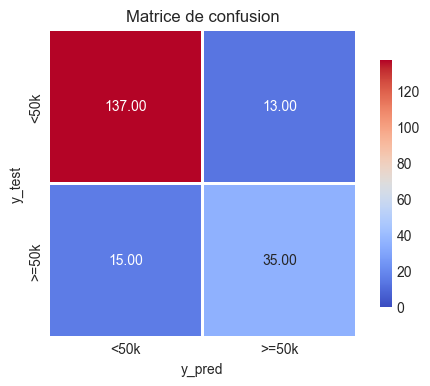

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_title("Matrice de confusion")
sns.heatmap(
    confusion_mat,
    annot=True,
    cmap="coolwarm",
    vmin=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    fmt=".2f",
    ax=ax,
)
ax.set_xlabel("y_pred")
ax.set_xticklabels(labels=["<50k", ">=50k"])
ax.set_ylabel("y_test")
ax.set_yticklabels(labels=["<50k", ">=50k"])

## Partie 5 : Sauvegarde et utilisation

### Tache 5.1 : Sauvegarder le pipeline

In [312]:
import joblib

# Sauvegarde dans un fichier pkl
model_file_name = "C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/exos/tp1_model.pkl"
joblib.dump(ml_pipeline, model_file_name)

['C:/Users/Administrateur/Documents/M2i_CDSD_TDTP/scikit_learn/exos/tp1_model.pkl']

### Tache 5.2 : Faire une prediction sur de nouvelles donnees

Creez un nouvel individu et predisez s'il gagne plus de 50K

In [315]:
new_person = pd.DataFrame({
    "age": [32],
    "education": ["Master"],
    "occupation": ["Cadre"],
    "secteur": ["Public"],
    "heures_semaine": [40],
    "experience": [5],
    "situation_familiale": ["Marie(e)"],
    "nb_enfants": [0],
    "region": ["Autres"],
    "teletravail": ["Jamais"],
    "anciennete_poste": [5],
    "satisfaction": [5],
})

prediction = ml_pipeline.predict(new_person)
proba = ml_pipeline.predict_proba(new_person)

print(f"Salaire > 50k : {"OUI" if prediction[0] == 1 else "NON"}")
print(f"proba : {proba[0][1]:.1%}")

Salaire > 50k : NON
proba : 21.4%
